# Motivating example - A bioreactor model
One of the goals for this course is to perform Bayesian inference on a system of differential equations, for example, modelling a bioreactor or a kinetic model of metabolism.

In this example lets work with a batch system where the product is inhibitory
$$ \mu = \frac{\frac{S}{K_S}}{1 + \frac{S}{K_S} + \frac{P}{K_P}} $$
with the following ODEs:

$$ \frac{dX}{dt} = \mu X$$
$$ \frac{dS}{dt} = -\gamma_S \mu X $$
$$ \frac{dP}{dt} = \gamma_P \mu P $$

**This example taken from the example on day 6**

In [73]:
def monod_kinetics(t, y, args):
    x, s, p = y
    mu_max = jnp.exp(args["log_mu_max"])
    ks = jnp.exp(args["log_ks"])
    kp = jnp.exp(args["log_kp"])
    gamma_s = jnp.exp(args["log_gamma_s"])
    gamma_p = jnp.exp(args["log_gamma_p"])
    mu = (mu_max * s/ks) / (1 + s/ks + p/kp)
    return jnp.array([mu * x, -gamma_s * mu * x, gamma_p * mu * x])

In [2]:
from functools import partial

import operator
import arviz as az
import diffrax
import numpy as np
import jax

from jax import numpy as jnp
from jax import scipy as jsp
from matplotlib import pyplot as plt

SEED = 12345
key = jax.random.key(seed=SEED)
rng_key, key = jax.random.split(key)
rng_key_a, rng_key_b, rng_key_c, rng_key_d = jax.random.split(rng_key, 4)

In [57]:
N_strain = 4
N_tube = 4
N_timepoint = 50
duration = 30
strains = [i + 1 for i in range(N_strain)]
tubes = [i + 1 for i in range(N_tube)]
species = ["biomass", "substrate", "product"]
measurement_times = np.array([4.0, 7.0, 12.0, 15.0, 17.0])
timepoints = jnp.linspace(0.01, duration, N_timepoint)

In [72]:
a_mu_max = -1.7
log_t_mu_max = jnp.log(0.2)
a_ks = -1.3
a_kp = -1.3
a_mu_max = -1.7
a_gamma_s = -0.6
a_gamma_p = -1.0
tau_mu_max = 0.2
tau_ks = 0.3
tau_kp = 0.3
tau_gamma_s = 0.13
tau_gamma_p = 0.13
target_conc_init = jnp.array([-2.1, 0.2, -4])
target_conc_init_scale = jnp.array([0.1, 0.05, 0.05])

true_params = {
    "a_mu_max": a_mu_max,
    "a_ks": a_ks,
    "a_kp": a_kp,
    "a_gamma_s": a_gamma_s,
    "a_gamma_p": a_gamma_p,
    "log_tau_mu_max": jnp.log(tau_mu_max),
    "log_tau_ks": jnp.log(tau_ks),
    "log_tau_kp": jnp.log(tau_kp),
    "log_tau_gamma_s": jnp.log(tau_gamma_s),
    "log_tau_gamma_p": jnp.log(tau_gamma_p),
    "log_conc_init": target_conc_init
    + target_conc_init_scale
    * jax.random.normal(
        key=rng_key_a,
        shape=(N_strain, 3),
    ),
    "log_sigma": jnp.log(jnp.array([0.08, 0.1, 0.1])),
    "log_mu_max": a_mu_max
    + tau_mu_max * jax.random.normal(rng_key_b, shape=(N_strain,)),
    "log_ks": a_ks + tau_ks * jax.random.normal(rng_key_c, shape=(N_strain,)),
    "log_kp": a_kp + tau_kp * jax.random.normal(rng_key_c, shape=(N_strain,)),
    "log_gamma_s": a_gamma_s
    + tau_gamma_s
    * jax.random.normal(
        rng_key_d,
        shape=(N_strain,),
    ),
    "log_gamma_p": a_gamma_p
    + tau_gamma_p
    * jax.random.normal(
        rng_key_d,
        shape=(N_strain,),
    ),
}


def get_strain_params(strain_ix, params):
    def slice(leaf):
        return (
            leaf[strain_ix]
            if (hasattr(leaf, "shape") and leaf.ndim > 0 and leaf.shape[0] == N_strain)
            else leaf
        )

    return jax.tree.map(slice, params)

### Defining the system of ODEs in diffrax

In [74]:
monod_term = diffrax.ODETerm(monod_kinetics)
solver = diffrax.Kvaerno5()
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
dt0 = 0.001
def solve_monod(args, timepoints):
    t0 = 0.0
    tf = timepoints[-1]
    y0 = jnp.exp(args["log_conc_init"])
    saveat = diffrax.SaveAt(ts=timepoints)
    return diffrax.diffeqsolve(
        monod_term,
        solver,
        t0=t0,
        t1=tf,
        dt0=dt0,
        y0=y0,
        saveat=saveat,
        args=args,
        stepsize_controller=stepsize_controller,
    )


### Solving an example

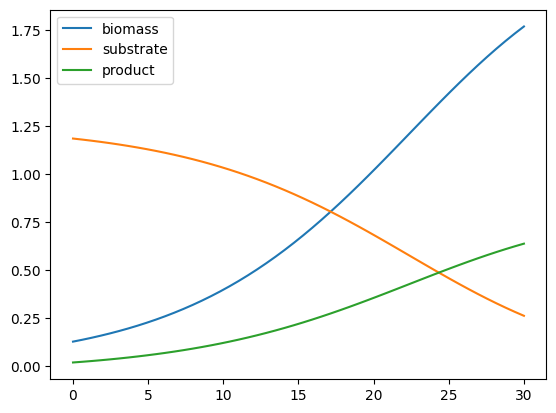

In [76]:
true_params_strain_2 = get_strain_params(2, true_params)
true_params_strain_2
solution = solve_monod(args=true_params_strain_2, timepoints=timepoints)
f, ax = plt.subplots()
for yi, label in zip(solution.ys.T, species):
    ax.plot(timepoints, yi, label=label)
ax.legend()

## Defining the posterior function

firstly lets assume a prior where the log-distributed parameters have approximately a 30% uncertainty

In [79]:
def prior_log_density(params, prior):
    loc, scale = prior
    return jax.tree.map(jsp.stats.norm.logpdf, params, loc, scale)

example_prior_loc = jax.tree.map(jnp.array, true_params)
example_prior_scale = jax.tree.map(
    lambda x: jnp.full_like(x, 0.3),
    true_params,
)
example_prior = (example_prior_loc, example_prior_scale)
example_log_prior = prior_log_density(true_params, example_prior)

In [81]:
def likelihood_log_density(obs, params, measurement_times):
    n_strain = params["log_mu_max"].shape[0]
    strains = jnp.arange(n_strain)
    yhat = jax.vmap(
        lambda i: solve_monod(get_strain_params(i, params), measurement_times).ys,
    )(strains)
    log_yhat = jnp.log(jnp.maximum(yhat, jnp.full_like(yhat, 1e-9)))
    sigma = jnp.exp(params["log_sigma"])
    log_obs = jnp.log(obs)
    return jsp.stats.norm.logpdf(log_obs, log_yhat, sigma)


def simulate_measurements(key, params, measurement_times):
    n_strain = params["log_mu_max"].shape[0]
    strains = jnp.arange(n_strain)
    yhat = jax.vmap(
        lambda i: solve_monod(get_strain_params(i, params), measurement_times).ys
    )(strains)
    sigma = jnp.exp(params["log_sigma"])
    noise = jax.random.normal(key, shape=yhat.shape) * sigma
    return jnp.exp(jnp.log(yhat) + noise)


sim_key, key = jax.random.split(key)
example_obs = simulate_measurements(sim_key, true_params, measurement_times)

In [82]:
def joint_log_density(params, obs, prior, measurement_times):
    lprior = prior_log_density(params, prior)
    llik = likelihood_log_density(obs, params, measurement_times)
    lprior_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, lprior))
    llik_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, llik))
    return lprior_sum + llik_sum


joint_log_density(true_params, example_obs,  example_prior, measurement_times)

Array(70.44479, dtype=float32)

### Posterior

When we have concrete values for observations, prior and measurement
times, we want a new function based on the joint log density, where
these values are fixed. This is an ideal job for the Python standard
library function `partial`. The resulting posterior log density function
has only one argument for parameters.

In [69]:
posterior_log_density = partial(
    joint_log_density,
    obs=example_obs,
    prior=example_prior,
    measurement_times=measurement_times
)
posterior_log_density(true_params)

Array(70.47508, dtype=float32)

## MCMC

Now we can generate posterior samples using adaptive Hamiltonian Monte
Carlo via the library
[blackjax](https://blackjax-devs.github.io/blackjax/).

> **Note**
>
> Multi-chain MCMC with Blackjax is a bit annoying to do manually so I
> made some convenience functions `run_nuts` and `get_idata`. These
> should probably already be installed - if not just run `uv sync` from
> the project root.

In [71]:
from blackjax_utils import run_nuts, get_idata
states, info = run_nuts(
    key,
    jax.jit(posterior_log_density),
    init_params=example_prior_loc,
    n_chain=4,
    n_warmup=200,
    n_sample=200,
    target_acceptance_rate=0.9,
    initial_step_size=0.001,
)

coords = {
    "strain": strains,
    "tube": tubes,
    "species": species,
    "timepoint": timepoints,
}
dims = {
    "log_conc_init": ["strain", "species"],
    "log_gamma_s": ["strain"],
    "log_gamma_p": ["strain"],
    "log_ks": ["strain"],
    "log_kp": ["strain"],
    "log_mu_max": ["strain"],
    "log_sigma": ["species"],
}

idata = get_idata(states, info, coords=coords, dims=dims)
n_divergent = idata.sample_stats["is_divergent"].sum().item()
print(f"Number of divergent transitions: {n_divergent}")
print(az.summary(idata))

Number of divergent transitions: 0
                              mean     sd  hdi_3%  hdi_97%  mcse_mean  \
a_gamma_p                   -1.002  0.318  -1.615   -0.376      0.008   
a_gamma_s                   -0.589  0.312  -1.139    0.008      0.009   
a_kp                        -1.294  0.296  -1.839   -0.744      0.008   
a_ks                        -1.301  0.326  -1.960   -0.740      0.008   
a_mu_max                    -1.708  0.300  -2.265   -1.161      0.009   
log_conc_init[1, biomass]   -1.949  0.079  -2.097   -1.807      0.003   
log_conc_init[1, substrate]  0.041  0.062  -0.090    0.147      0.002   
log_conc_init[1, product]   -3.942  0.187  -4.307   -3.636      0.006   
log_conc_init[2, biomass]   -2.264  0.076  -2.410   -2.125      0.002   
log_conc_init[2, substrate]  0.154  0.048   0.058    0.238      0.001   
log_conc_init[2, product]   -4.099  0.186  -4.478   -3.790      0.008   
log_conc_init[3, biomass]   -2.043  0.085  -2.220   -1.896      0.004   
log_conc_init[3,

# Posterior predictive check
We can then take the draws from the MCMC sampling and then simulate the posterior samples. By doing this we can confirm whether we are effectively sampling the posterior space.

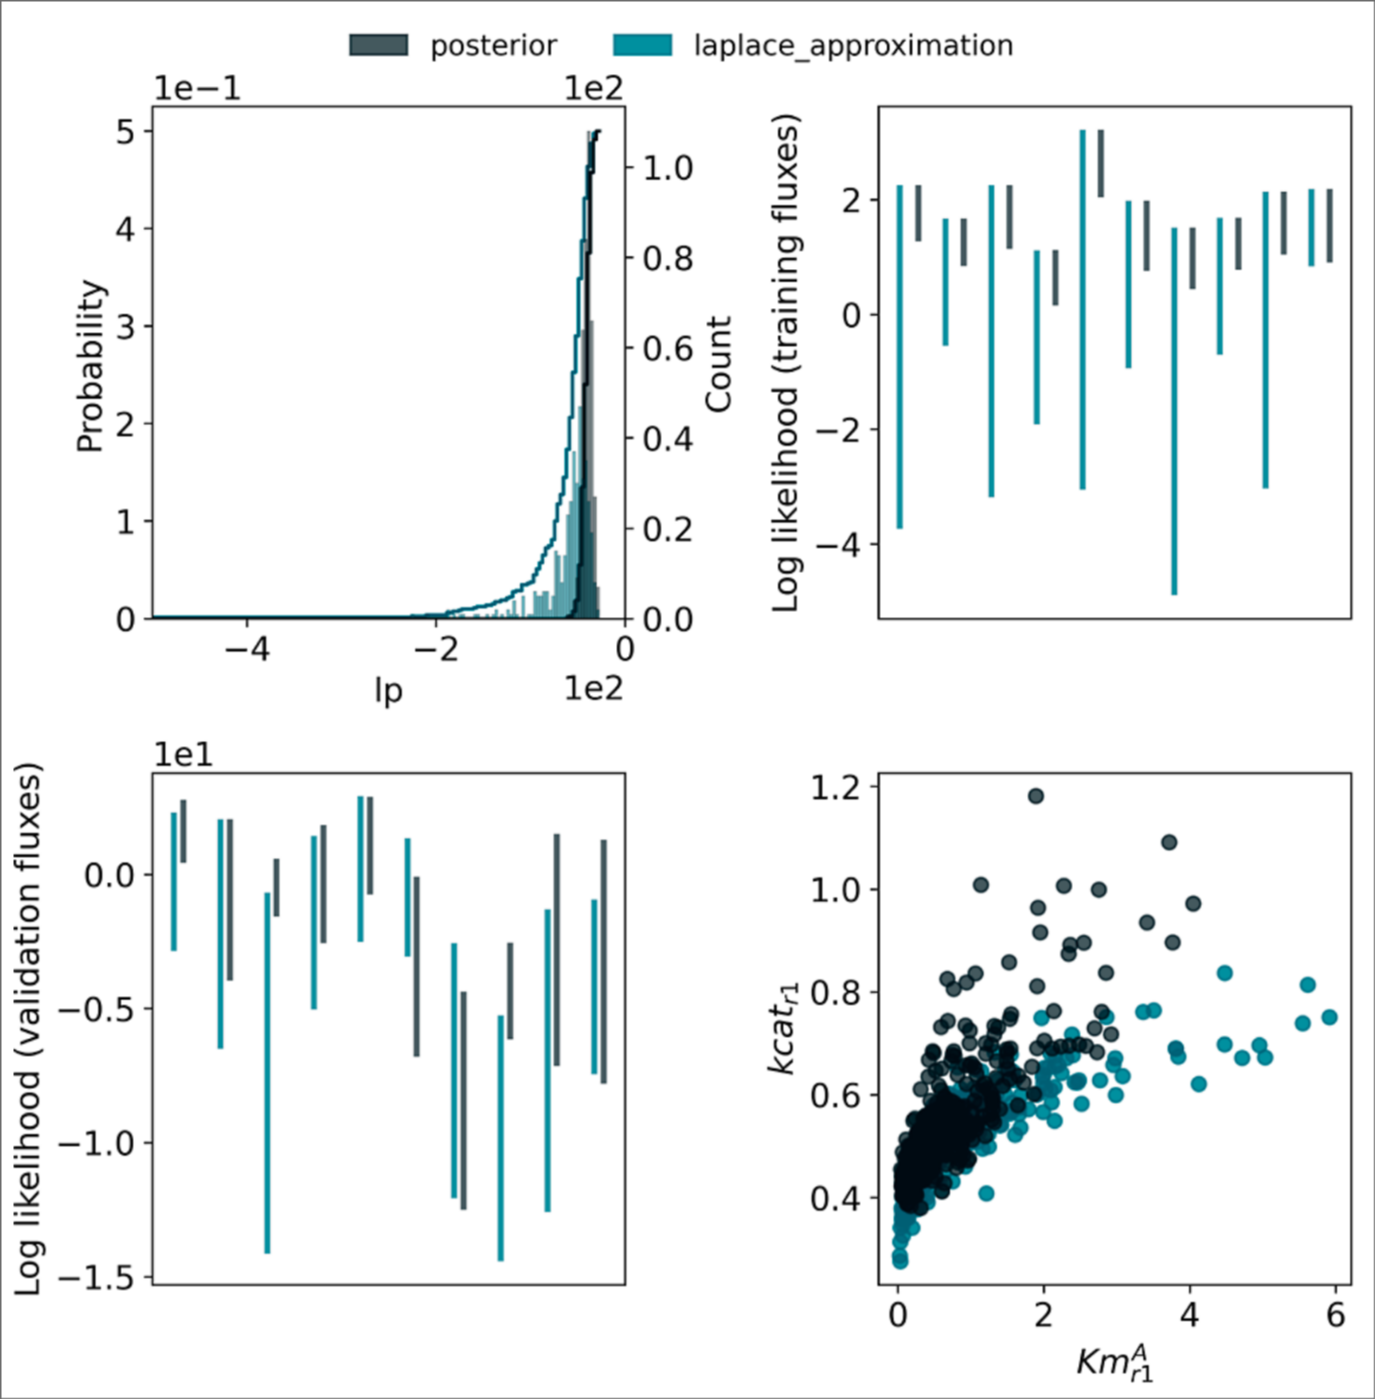

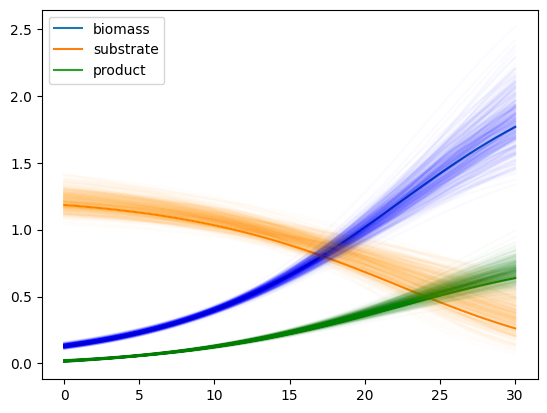

In [115]:
strain = 2

true_params_strain_2 = get_strain_params(strain, true_params)
true_params_strain_2
solution = solve_monod(args=true_params_strain_2, timepoints=timepoints)
f, ax = plt.subplots()
for yi, label in zip(solution.ys.T, species):
    ax.plot(timepoints, yi, label=label)
ax.legend()

for chain in range(4):
    for draw in range(100):
        args_sim = {
            "log_mu_max": idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_mu_max"]["data"][strain],
            "log_ks": idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_ks"]["data"][strain],
            "log_kp": idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_kp"]["data"][strain],
            "log_gamma_s": idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_gamma_s"]["data"][strain],
            "log_gamma_p": idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_gamma_p"]["data"][strain],
            "log_conc_init": np.array(idata.posterior.sel(chain=chain, draw=draw).to_dict()["data_vars"]["log_conc_init"]["data"][strain]),
        }
        sol = solve_monod(args=args_sim, timepoints=timepoints)
        for yi, label, c in zip(sol.ys.T, species, ["b", "orange", "g"]):
            ax.plot(timepoints, yi, alpha=0.02, color=c)

